### S15. Aprenentatge No Supervisat - Agrupació

In [1]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures, RobustScaler, MinMaxScaler

##### Load the database

In [2]:
#Loading the dataset
df=pd.read_csv('delayedflights.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [3]:
#select the relevant attributes for an objective prediction before flying.  
df=df[['Month', 'DayOfWeek', 'DepTime','ArrTime', 'UniqueCarrier', 'CRSElapsedTime', 
       'Origin', 'Dest', 'Distance','DepDelay','CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','ArrDelay']]
df = df.sample(frac =.05).reset_index().drop(['index'], axis=1)
df.head(3)

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,Distance,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
0,2,7,2146.0,2228.0,WN,45.0,MCO,RSW,133,6.0,NaN,NaN,NaN,NaN,NaN,3.0
1,10,7,1755.0,1938.0,YV,88.0,BUR,PHX,369,75.0,90.0,0.0,0.0,0.0,0.0,90.0
2,8,7,1033.0,1242.0,US,176.0,PHL,FLL,992,33.0,NaN,NaN,NaN,NaN,NaN,-14.0


In [4]:
# Delete both ArrTime and ArrDelay (target column) null values because they are most likely linked to cancellations and diverions
df.dropna(subset=['ArrTime','UniqueCarrier','ArrDelay'], inplace=True)

In [5]:
df.isnull().sum()

Month                    0
DayOfWeek                0
DepTime                  0
ArrTime                  0
UniqueCarrier            0
CRSElapsedTime           0
Origin                   0
Dest                     0
Distance                 0
DepDelay                 0
CarrierDelay         34080
WeatherDelay         34080
NASDelay             34080
SecurityDelay        34080
LateAircraftDelay    34080
ArrDelay                 0
dtype: int64

In [6]:
# Convert selected columns nulls to 0
cols= ['CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
df[cols]=df[cols].fillna(0)

In [7]:
#bin Delay related columns by 10 mins and also preprocess with QuantileTransformer
def truncate(n):
    if n < 10:
        min=0
    elif n<100:
        low=str(n)
        min=int(low[0])*10
    elif n<1000:
        low=str(n)
        min=int(low[0:2])*10
    else:
        low=str(n)
        min=int(low[0:3])*10
    return min

scaler = QuantileTransformer()
cols= ['DepDelay','ArrDelay','CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
for co in cols:
    df[co] = df[co].apply(truncate)
    df[[co]] = scaler.fit_transform(df[[co]])

In [8]:
df.head(10)

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,Distance,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
0,2,7,2146.0,2228.0,WN,45.0,MCO,RSW,133,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,10,7,1755.0,1938.0,YV,88.0,BUR,PHX,369,0.836336,0.971972,0.0,0.000000,0.0,0.000000,0.877878
2,8,7,1033.0,1242.0,US,176.0,PHL,FLL,992,0.615616,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,1,6,1500.0,1707.0,EV,72.0,MOB,ATL,302,0.931932,0.949950,0.0,0.950450,0.0,0.000000,0.912412
4,3,1,12.0,817.0,B6,301.0,SEA,JFK,2421,0.292793,0.000000,0.0,0.000000,0.0,0.722222,0.347848
6,8,2,922.0,1026.0,UA,134.0,MSP,DEN,680,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
7,12,4,1311.0,1344.0,HA,34.0,OGG,HNL,100,0.292793,0.000000,0.0,0.000000,0.0,0.000000,0.347848
8,3,5,1649.0,1926.0,US,331.0,CLT,LAX,2125,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.347848
9,6,1,1642.0,1753.0,MQ,70.0,BOS,LGA,185,0.864364,0.000000,0.0,0.972472,0.0,0.000000,0.854855
10,6,1,956.0,1555.0,AA,230.0,SEA,DFW,1660,0.493994,0.000000,0.0,0.000000,0.0,0.722222,0.604104


In [9]:
#delete the exceptional single outlier
df=df.drop(df['DepDelay'].idxmax())

In [10]:
##### Frequency Encoding columna Month, DayOfWeek i UniqueCarrier
freq=['UniqueCarrier','Origin','Dest']
for xx in freq:
    fe=df.groupby(xx).size()/len(df)
    df.loc[:,xx]=df[xx].map(fe)

##### Preprocessing time columns as cyclical

In [11]:
#hores de sortida/arribada
df['DepTime_sin'] = np.sin(df.DepTime*(2.*np.pi/2400))
df['DepTime_cos'] = np.cos(df.DepTime*(2.*np.pi/2400))
df['ArrTime'] = np.sin(df.ArrTime*(2.*np.pi/2400))
df['ArrTime'] = np.cos(df.ArrTime*(2.*np.pi/2400))

# mesos
df['Month_sin'] = np.sin((df.Month-1)*(2.*np.pi/12))
df['Month_cos'] = np.cos((df.Month-1)*(2.*np.pi/12))

# dies setmana
df['DayOfWeek_sin'] = np.sin((df.DayOfWeek-1)*(2.*np.pi/7))
df['DayOfWeek_cos'] = np.cos((df.DayOfWeek-1)*(2.*np.pi/7))


#drop the original columns
df=df.drop(['Month','DayOfWeek','DepTime','ArrTime'], axis=1)

In [12]:
# Preprocess with MinMax Scaler CRSElapsedTime and Distance columns
minmax = MinMaxScaler()
df[["CRSElapsedTime", "Distance"]] = minmax.fit_transform(df[["CRSElapsedTime", "Distance"]])

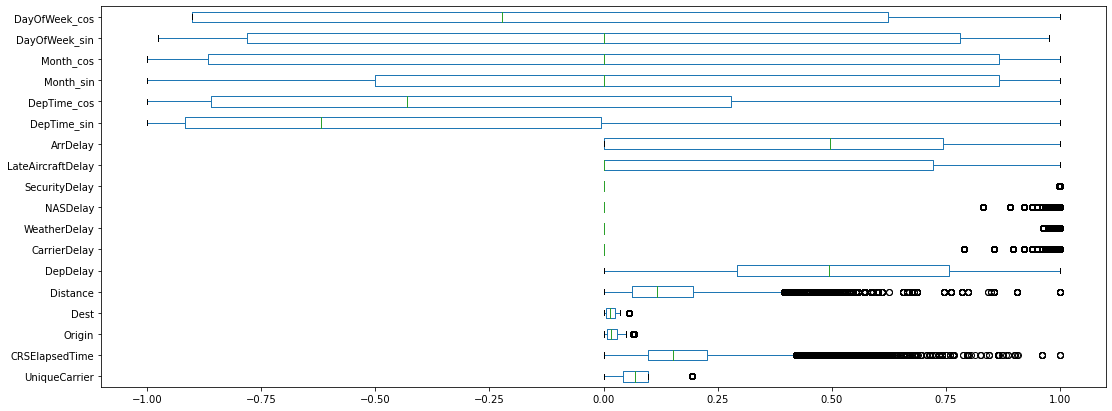

In [13]:
df.plot(kind='box',figsize=(18,7),vert=False)

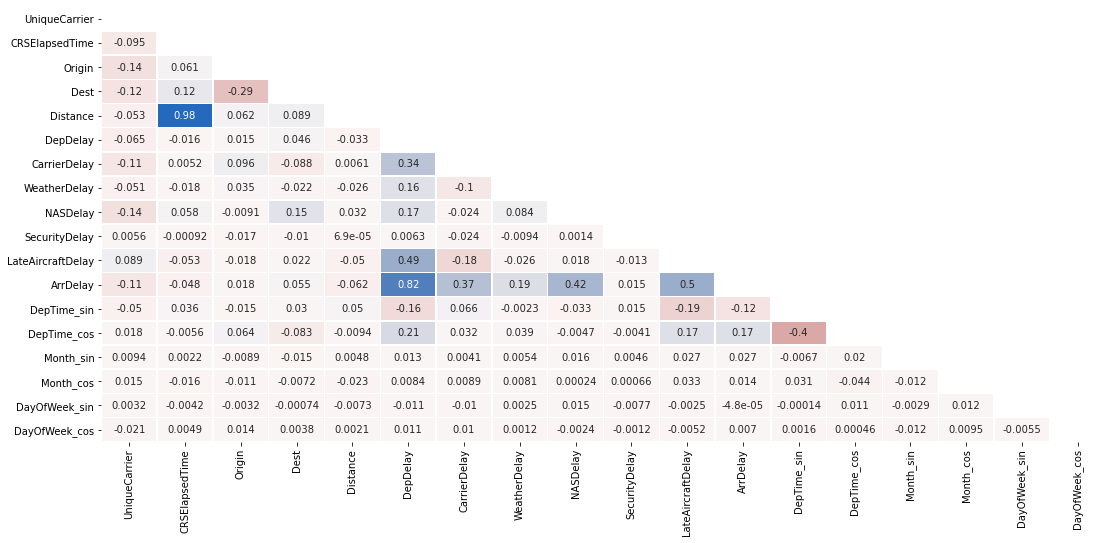

In [14]:
# Correlation Heatmap 
corr = df.corr()
cmap = sns.light_palette("#0c2a70", as_cmap=True)
mask = np.triu(corr)
plt.figure(figsize=(18,8))
sns.heatmap(corr, cmap='vlag_r', annot=True, linewidths=0.5, center=0, cbar=False, xticklabels=True,
           mask=mask)

In [15]:
df=df.drop(['Distance'],axis=1)

In [16]:
df.to_csv('delays_prep2.csv')

In [17]:
df

,UniqueCarrier,CRSElapsedTime,Origin,Dest,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay,DepTime_sin,DepTime_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,0.193752,0.039062,0.018624,0.003787,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,-0.617036,0.786935,0.500000,8.660254e-01,-0.781831,0.623490
1,0.034924,0.106250,0.003600,0.025005,0.836336,0.971972,0.0,0.00000,0.0,0.000000,0.877878,-0.993068,-0.117537,-1.000000,-1.836970e-16,-0.781831,0.623490
2,0.051452,0.243750,0.015501,0.010625,0.615616,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.423409,-0.905939,-0.500000,-8.660254e-01,-0.781831,0.623490
3,0.041647,0.081250,0.000674,0.056017,0.931932,0.949950,0.0,0.95045,0.0,0.000000,0.912412,-0.707107,-0.707107,0.000000,1.000000e+00,-0.974928,-0.222521
4,0.028190,0.439063,0.015719,0.018499,0.292793,0.000000,0.0,0.00000,0.0,0.722222,0.347848,0.031411,0.999507,0.866025,5.000000e-01,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96833,0.193752,0.187500,0.039302,0.013146,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.996493,-0.083678,0.000000,1.000000e+00,0.433884,-0.900969
96834,0.069018,0.106250,0.000581,0.025067,0.615616,0.000000,0.0,0.92042,0.0,0.000000,0.604104,0.816642,-0.577145,-0.866025,-5.000000e-01,-0.781831,0.623490
96835,0.020056,0.220313,0.015719,0.013644,0.886386,0.959459,0.0,0.00000,0.0,0.000000,0.825826,-0.690251,0.723570,0.000000,1.000000e+00,-0.974928,-0.222521
96836,0.074154,0.356250,0.013447,0.056526,0.950951,0.000000,0.0,0.00000,0.0,0.975475,0.925425,-0.790155,-0.612907,0.500000,-8.660254e-01,-0.433884,-0.900969
